In [6]:
import matplotlib.pyplot as plt

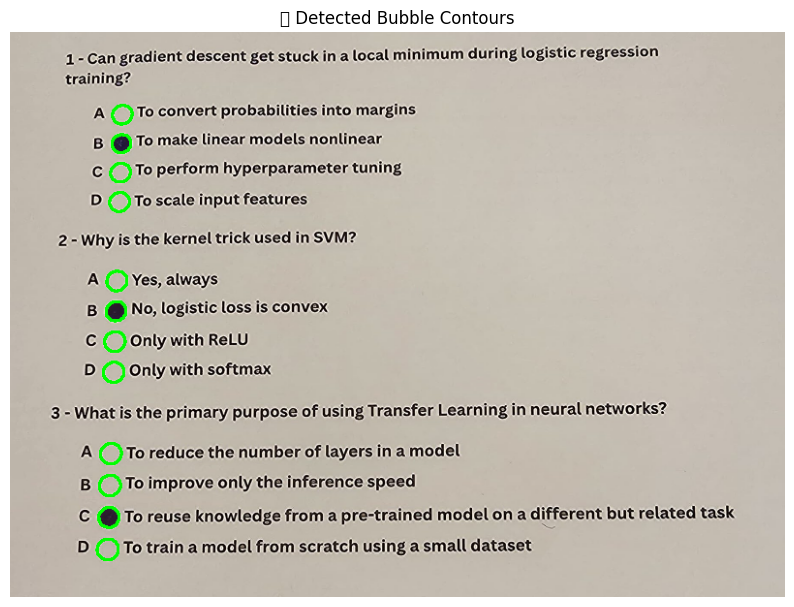

Student Answers: {1: ['B'], 2: ['C'], 3: ['C']}
Score: 2 / 3


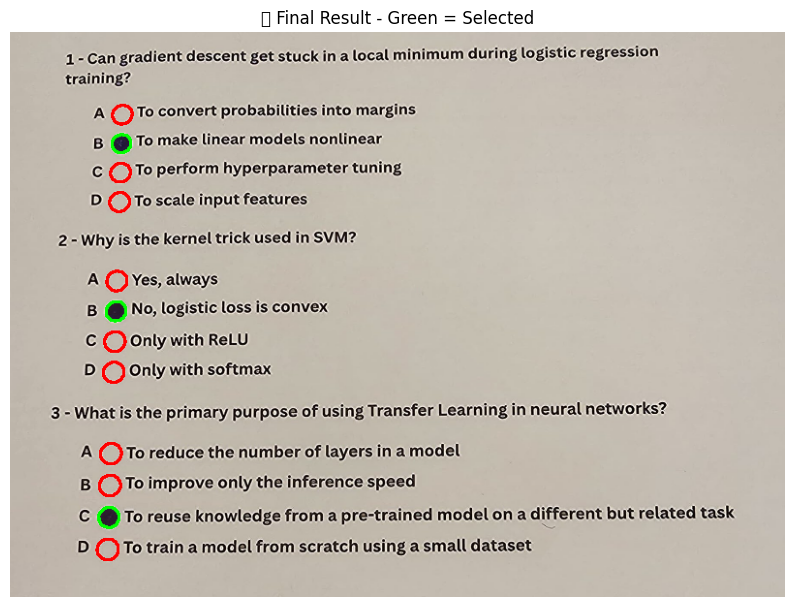

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# =========================================
# 1. PARAMETERS
# =========================================
IMG_PATH = "/content/tetetetetete.jpg"  
NUM_QUESTIONS = 3
CHOICES_PER_Q = 4
FILL_RATIO_THRESH = 0.15  # How much of the bubble must be filled
ANSWER_KEY = {1: ["B"], 2: ["B"], 3: ["C"]}

# =========================================
# 2. LOAD IMAGE AND PREPROCESS
# =========================================
orig = cv2.imread(IMG_PATH)
assert orig is not None, "❌ Image not found."

resized = cv2.resize(orig, (800, int(orig.shape[0] * 800 / orig.shape[1])))
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

# --- Enhance Dark Circles ---
shadow = cv2.GaussianBlur(gray, (25, 25), 0)
norm = cv2.divide(gray, shadow, scale=255)

# Sharpen
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharp = cv2.filter2D(norm, -1, kernel)

# Gamma correction
gamma = 1.5
invG = 1. / gamma
table = np.array([((i / 255.) ** invG) * 255 for i in range(256)]).astype("uint8")
enhanced = cv2.LUT(sharp, table)

# Threshold
thresh = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

# =========================================
# 3. FIND BUBBLE CONTOURS
# =========================================
cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bubbles = []

for c in cnts:
    area = cv2.contourArea(c)
    if 100 < area < 4000:
        x, y, w, h = cv2.boundingRect(c)
        aspect_ratio = w / float(h)
        if 0.8 < aspect_ratio < 1.2:
            bubbles.append(c)

# Debug: Show detected bubbles
debug_img = resized.copy()
cv2.drawContours(debug_img, bubbles, -1, (0, 255, 0), 2)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
plt.title("✅ Detected Bubble Contours"); plt.axis('off'); plt.show()

if not bubbles:
    raise Exception("❌ No bubble contours detected.")

# =========================================
# 4. SORT & GROUP BUBBLES
# =========================================
def sort_contours(cnts, method="top-to-bottom"):
    reverse = False
    i = 1 if method in ["right-to-left", "bottom-to-top"] else 0
    if method in ["right-to-left", "bottom-to-top"]: reverse = True
    bounding_boxes = [cv2.boundingRect(c) for c in cnts]
    cnts, _ = zip(*sorted(zip(cnts, bounding_boxes), key=lambda b: b[1][i], reverse=reverse))
    return list(cnts)

bubbles = sort_contours(bubbles, method="top-to-bottom")

bubble_groups = []
for i in range(0, len(bubbles), CHOICES_PER_Q):
    group = sort_contours(bubbles[i:i + CHOICES_PER_Q], method="left-to-right")
    bubble_groups.append(group)

if len(bubble_groups) < NUM_QUESTIONS:
    raise Exception("❌ Not enough groups detected.")

# =========================================
# 5. DETECT FILLED BUBBLES
# =========================================
student_answers = defaultdict(list)

for q_idx, group in enumerate(bubble_groups[:NUM_QUESTIONS]):
    if len(group) < CHOICES_PER_Q:
        print(f"⚠️ Question {q_idx+1} has only {len(group)} bubbles.")
        student_answers[q_idx + 1] = []
        continue


    best_choice = None
    best_ratio = 0

    for j, c in enumerate(group):
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [c], -1, 255, -1)

        total_pixels = cv2.countNonZero(mask)
        filled_pixels = cv2.countNonZero(cv2.bitwise_and(thresh, thresh, mask=mask))
        ratio = filled_pixels / float(total_pixels)

        # 🟢 Select bubble with highest fill ratio above the threshold
        if ratio > best_ratio and ratio > FILL_RATIO_THRESH:
            best_ratio = ratio
            best_choice = chr(65 + j)

    if best_choice:
        student_answers[q_idx + 1] = [best_choice]
    else:
        student_answers[q_idx + 1] = []

# =========================================
# 6. SCORING
# =========================================
score = sum(set(student_answers[q]) == set(ANSWER_KEY[q]) for q in ANSWER_KEY)
print("Student Answers:", dict(student_answers))
print(f"Score: {score} / {NUM_QUESTIONS}")

# =========================================
# 7. VISUALIZE RESULT
# =========================================
vis = resized.copy()
for q_idx, group in enumerate(bubble_groups[:NUM_QUESTIONS]):
    for j, c in enumerate(group):
        color = (0, 255, 0) if chr(65 + j) in student_answers[q_idx + 1] else (0, 0, 255)
        cv2.drawContours(vis, [c], -1, color, 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("🟢 Final Result - Green = Selected")
plt.axis('off'); plt.show()
